In [2]:
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.2);
sns.set_style("whitegrid");

In [3]:
###util methods
def plot_scatter_annotated(dataset,labels):
	X = dataset.values
	plt.figure(figsize=(10,10))
	plt.scatter(X[:,0], X[:,1],s=100)
	
	for i, (x, y) in enumerate(zip(X[:, 0], X[:, 1])):
	    plt.annotate(
	        labels[i], 
	        xy = (x, y), xytext = (-20, 20),
	        textcoords = 'offset points', ha = 'right', va = 'bottom',
	        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
	        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))	

# 7. Clustering

So far we have seen learning algorithms for **supervised data analysis**, i.e. the label or target was known for each data point. However, as labeling data can be hard and/or costly, most data that is collected is unlabeled. Learning from unlabeled data is known as **unsupervised learning** in which we look for hidden **structure** in the data that can learn us something about the true model(s) that generated the data. 

**Clustering** is a class of unsupervised learning methods that associates observations according to some specified **measure of similarity** (e.g. Euclidean distance). In its basic form (many variations exist) it tries to cluster the unlabeled data points into groups such that data points in the same group (**cluster**) are more similar to each other than those in other groups. Typical applications of clustering in bioinformatics include finding genes that co-express, proteins that interact, finding sub-populations in disease types, and image analysis tasks such as the segmentation of raw medical image data. Two popular algorithms for unsupervised data clustering are K-means and hierarchical agglomerative clustering.

The **K-means clustering algorithm** associates each data point $x^{(i)}$ in a data set ($i=1 \ldots n$) to one of $K$ clusters. Each cluster is specified by a **centroid** that is the average location of all the points in the cluster. The algorithm proceeds iteratively from arbitrary centroid locations, updating the membership of each point according to minimum distance and then updating the centroid location based on the new cluster membership. The algorithm converges when the assignment of points to centroids does not change anymore with each iteration. 

We can formalize this as follows:



1. Initialize cluster centroids (e.g. *at random*):

    $\mu^{(0)}_1, \ldots, \mu^{(0)}_k \in \mathbb{R}^n.$

2. Iterate steps ($s=0$) until converged:

    a. for each data point $x^{(i)}$ find the closest centroid 
    
    $c_i = \underset{j}{\operatorname{argmin}} || x^{(i)} - \mu_j^{(s)}||,$
    
    b. update the centroids as
    
    $\mu_j^{(s+1)} = \frac{\sum_{i=1}^n I[c_i = j] x^{(i)}}{\sum_{i=1}^n I[c_i = j]},$
    
    where $I[c_i = j]$ equals 1 if $c_i$ equals $j$ and 0 otherwise. 
    
    Let's show how this works on an artificial data set with four clusters in two dimensions: 

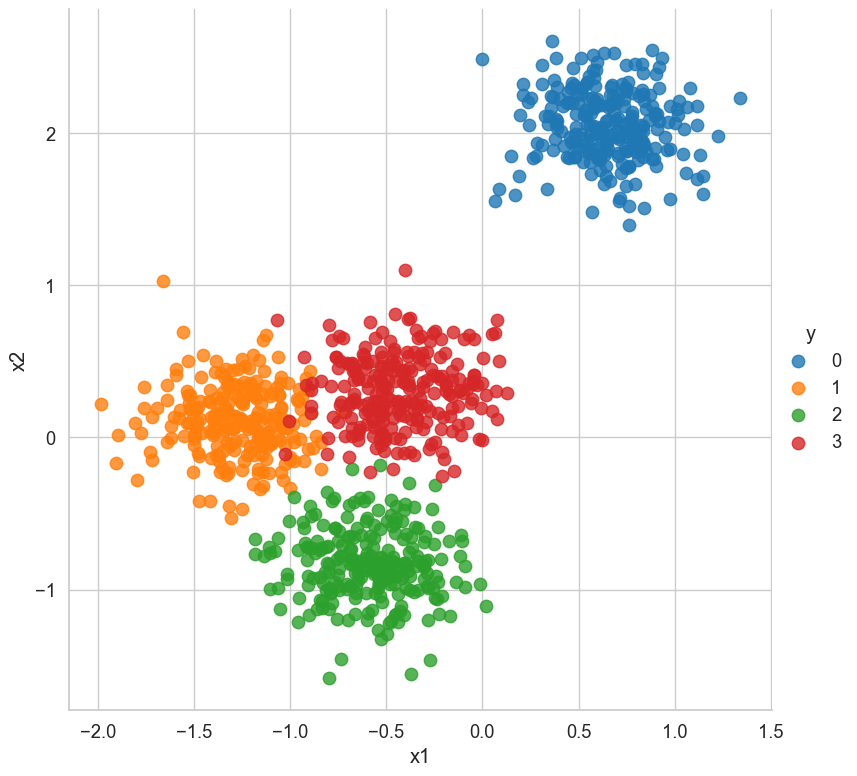

In [4]:
dataset_blops = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/7_clustering/dataset_blops.csv")

sns.lmplot(x="x1", y="x2", hue='y', data=dataset_blops, fit_reg=False, height=8, scatter_kws={"s": 80})
plt.show()

For this data set we know that there are 4 clusters indicated by the target column '$y$'. In real unlabeled data sets this information would not be available. First we initialize the 4 cluster centroids randomly:

In [5]:
np.random.seed(1)
start_centroids = 3*(np.random.rand(4,2)-0.5)

We can then plot these centroids:

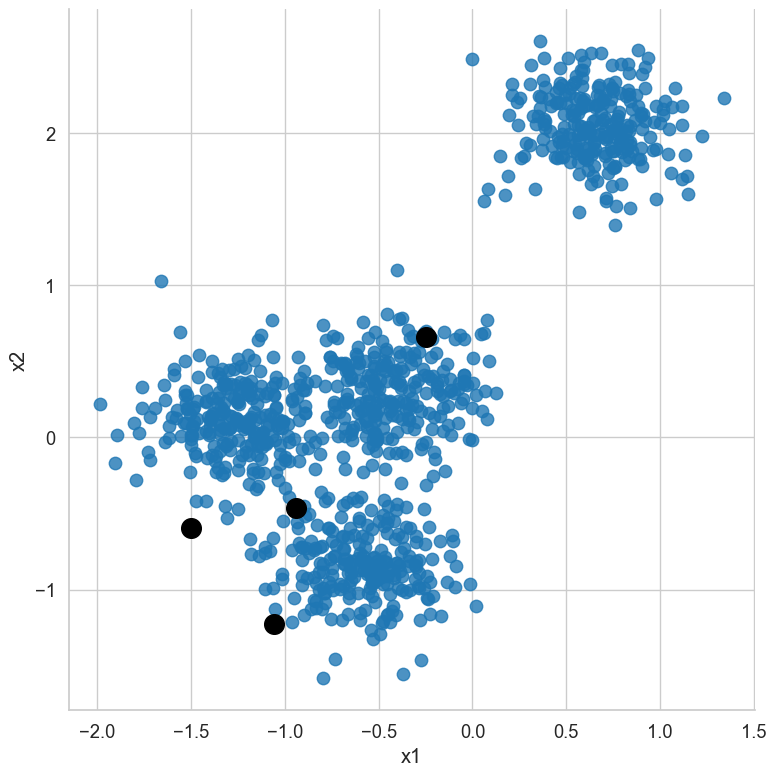

In [6]:
sns.lmplot(x="x1", y="x2", data=dataset_blops, fit_reg=False, height=8, scatter_kws={"s": 80})
plt.scatter(*start_centroids.T, c='k', marker='o', s=200)
plt.show()

Now we have to compute the distance between the centroids and the data points ($|| x^{(i)} - \mu_j^{(s)} ||$) to find the closest centroid $\mu_j^{(s)}$ for each data point $x^{(i)}$:

$$\text{argmin}_j || x^{(i)} - \mu_j^{(s)} ||$$


We can use the function `cdist` from the python SciPy package to calculate the distances from each point to each centroid:

In [8]:
from scipy.spatial.distance import cdist

distances = cdist(start_centroids, dataset_blops[['x1','x2']])
print(distances)

[[1.20634621 1.43982668 1.71735561 ... 1.84102522 1.46099393 0.92719821]
 [0.86109144 1.17529094 3.48072205 ... 3.42306106 3.20142735 1.14978231]
 [1.51931364 0.84830676 3.74046224 ... 3.85611564 3.50768925 1.73251361]
 [0.85019351 0.67883881 3.03403238 ... 3.09449049 2.78063518 0.9948306 ]]


Now, for each column $i$ in *distances* we can find the row $j$ for which the value of that column is smallest. So for each data point $x^{(i)}$ we assigned the row number of the closest centroid $\mu_j^{(s)}$:

In [9]:
labels = distances.argmin(axis=0)
print(labels)

[3 3 0 3 2 0 0 0 0 3 0 0 0 0 0 0 0 3 0 3 1 0 1 0 1 3 2 3 0 1 2 3 3 3 0 0 0
 0 3 3 1 0 3 0 3 3 3 0 2 2 0 1 0 1 0 3 0 3 3 0 3 3 0 3 3 0 0 0 0 3 0 3 0 0
 3 0 0 1 0 0 3 3 3 0 0 3 0 2 0 3 2 0 0 0 0 0 0 3 0 3 3 3 0 0 1 0 3 0 0 0 0
 3 3 0 2 0 0 0 3 1 0 0 0 0 2 2 0 3 0 0 0 3 0 0 3 0 3 1 2 3 3 3 3 3 1 0 0 3
 3 2 3 0 3 0 3 0 3 1 2 3 3 0 0 2 3 3 0 3 0 0 3 3 3 3 3 1 0 0 3 2 3 3 0 1 3
 0 3 3 3 0 0 2 0 3 0 0 3 1 0 3 0 3 2 3 0 0 3 0 3 0 3 0 3 1 3 0 0 0 1 0 0 3
 2 0 0 3 0 0 1 0 0 0 0 1 0 0 0 3 2 0 0 0 0 0 0 3 3 0 0 0 2 3 0 0 0 2 3 0 3
 3 0 3 3 3 3 0 3 3 0 2 0 3 3 3 3 0 0 3 1 3 0 3 0 1 3 0 0 0 2 0 1 0 0 0 3 0
 3 3 3 0 3 3 0 1 1 1 3 3 3 3 3 0 0 0 3 0 0 0 2 3 3 3 0 0 0 0 0 3 3 3 0 2 3
 2 0 0 0 0 2 3 3 3 0 0 0 2 3 0 0 2 0 0 0 3 3 3 0 2 3 2 0 1 0 0 1 0 3 0 0 0
 0 1 0 3 0 0 0 3 2 0 0 3 3 2 3 0 0 0 3 0 3 0 3 0 3 2 2 2 3 3 3 3 0 3 2 3 3
 3 0 3 0 0 2 0 0 1 0 3 3 0 0 0 3 0 0 3 3 3 0 3 3 3 2 2 0 0 2 3 3 0 3 3 0 2
 0 0 0 3 0 3 3 1 0 3 0 3 3 2 0 0 3 0 0 1 3 1 2 0 0 1 1 0 3 3 0 3 0 3 3 3 3
 1 1 2 0 0 3 0 0 0 0 2 2 

We now associated each data point with a cluster centroid.

Let's plot this:

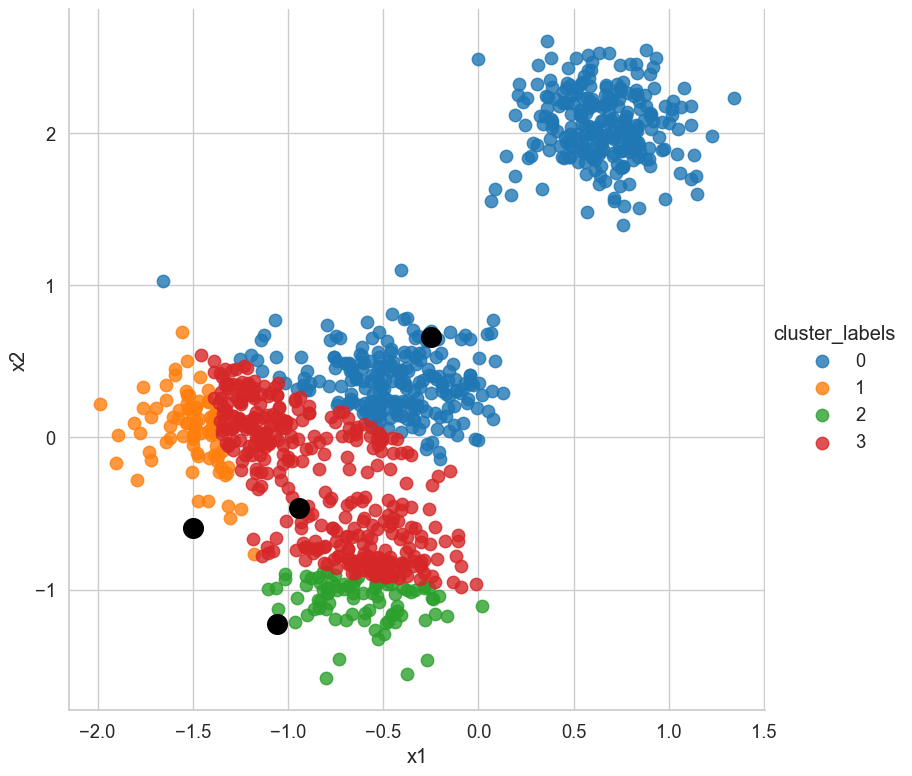

In [10]:
dataset_blops['cluster_labels'] = labels

sns.lmplot(x="x1", y="x2", data=dataset_blops, hue='cluster_labels', fit_reg=False, height=8, scatter_kws={"s": 80})
plt.scatter(*start_centroids.T, c='k', marker='o', s=200)
plt.show()

Now we can re-assign the centroid locations based on the means of the current members' locations:

<br>
$$\mu_j^{(s+1)} = \frac{\sum_{i=1}^n I[c_i = j] x^{(i)}}{\sum_{i=1}^n I[c_i = j]}.$$
<br>


In [11]:
new_centroids = dataset_blops[['x1','x2','cluster_labels']].groupby('cluster_labels').mean().values
print(new_centroids)

[[ 0.13479946  1.25463108]
 [-1.51088298  0.04193291]
 [-0.61270246 -1.06978551]
 [-0.83172151 -0.27627162]]


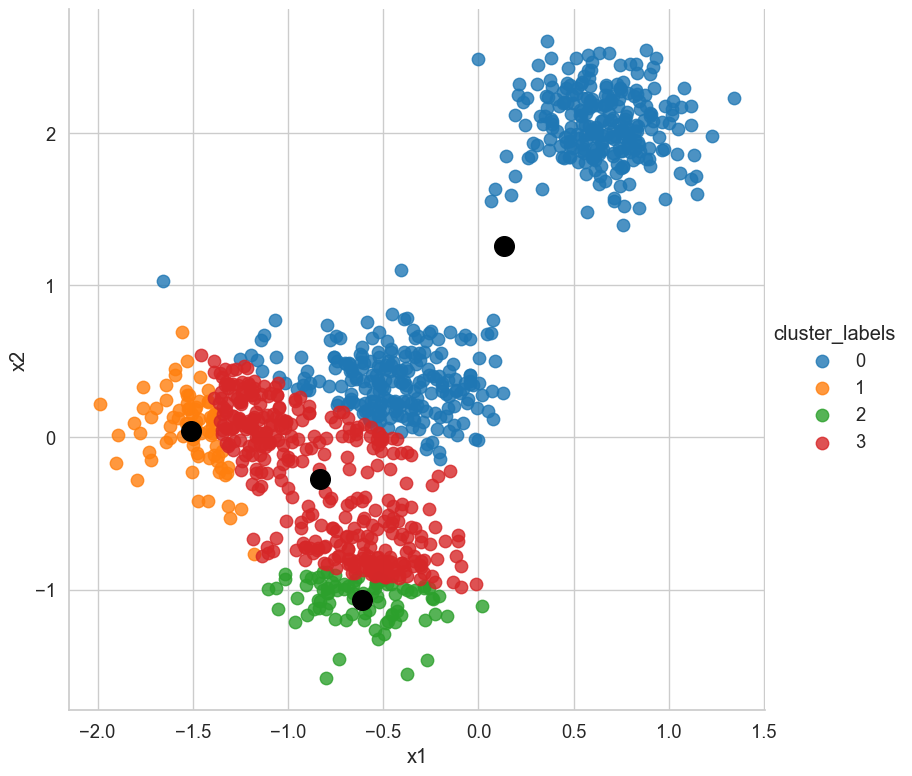

In [12]:
sns.lmplot(x="x1", y="x2", data=dataset_blops, hue='cluster_labels', fit_reg=False, height=8, scatter_kws={"s": 80})
plt.scatter(*new_centroids.T, c='k', marker='o', s=200)
plt.show()

Now we iterate these steps until convergence:

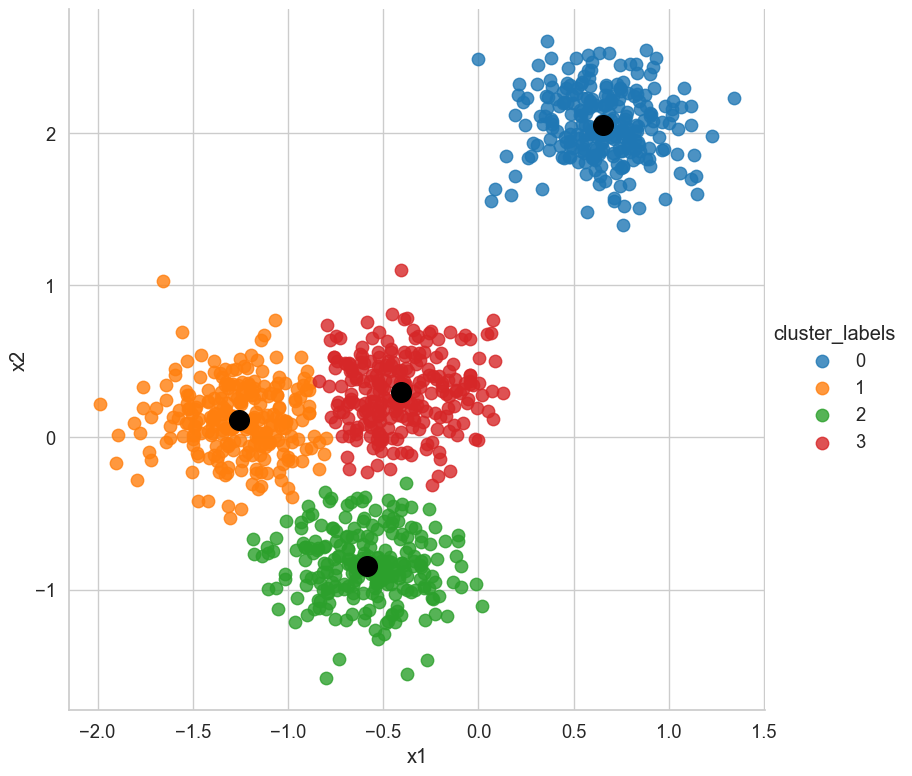

In [13]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4,max_iter=10,n_init=1,init=start_centroids)
km.fit(dataset_blops[['x1','x2']])

dataset_blops['cluster_labels'] = km.labels_

sns.lmplot(x="x1", y="x2", data=dataset_blops, hue='cluster_labels', fit_reg=False, height=8, scatter_kws={"s": 80})
plt.scatter(*km.cluster_centers_.T, c='k', marker='o', s=200)
plt.show()

Let's do the exercise again with a different random initiation of the centroids (random seed is set to 5 instead of 1). We can see that this time the K-means algorithm fails to converge correctly.

The **K-means++ algorithm** works the same as K-means but computes a smarter initialization of the centroids. The intuition behind this approach is that spreading out the $k$ initial centroids is a good thing: the first centroid is chosen uniformly at random from the data points that are being clustered, after which each subsequent centroid is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing centroid.

The K-means algorithm is very sensitive to the scale of the features. In the example below we create an artificial data set in which the scale of feature $x_1$ is much larger than the scale of feature $x_2$:

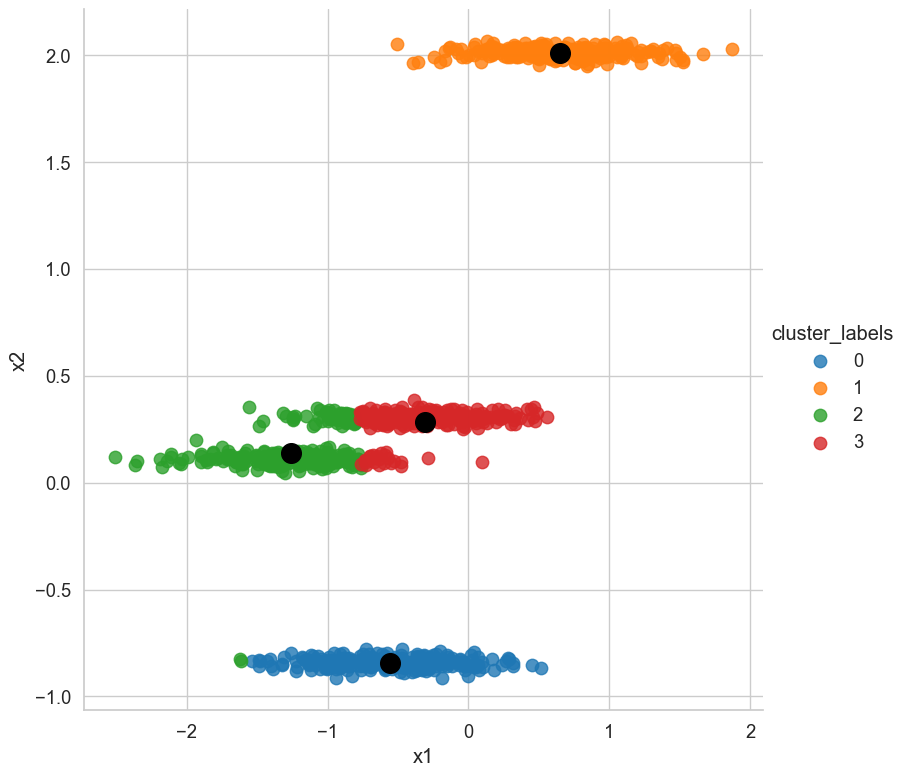

In [14]:
dataset_blops_scale = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/7_clustering/dataset_blops_scale.csv")

km = KMeans(n_clusters=4,max_iter=10)
km.fit(dataset_blops_scale[['x1','x2']])

dataset_blops_scale['cluster_labels'] = km.labels_

sns.lmplot(x="x1", y="x2", data=dataset_blops_scale, hue='cluster_labels', fit_reg=False, height=8, scatter_kws={"s": 80})
plt.scatter(*km.cluster_centers_.T, c='k', marker='o', s=200)
plt.show()

We observe how K-means++ fails to find the correct clusters. Scaling the features before applying K-means is highly recommended.

In real clustering tasks it is typically not known how many data clusters to expect. In this case we have to choose the number of clusters $k$ based on some criteria. One of those is the **silhouette coefficient** that measures how close various clusters are. A higher silhouette score is better as it means that we don't have too many overlapping clusters.

To compute the silhouette score we first compute two data point properties: **cohesion** and **separation**. The cohesion $a(x)$ of a data point $x$ measures how closely related the points in a cluster are. It is computed as the mean distance between the data point and all other points in the same cluster. Separation measures how well-separated a cluster is from the other features. The separation $b(x)$ of a data point $x$ is computed as the mean distance between the data point and all other points in the next nearest cluster.

The silhouette score $s(x)$ for a data point $x$ is computed as 

<br>
$$s(x)=\frac{b(x)-a(x)}{max(a(x),b(x))}.$$
<br>

The silhouette coefficient $SC$ for a given clustering of the data points is then computed as 

<br>
$$SC = \frac{1}{n}\sum\limits_{i=1}^ns(x).$$
<br>

The quality of a clustering can also be measured by the **inertia**. This metric is used to estimate how close the data points in a cluster are (a bit like cohesion discussed above). It is calculated as the sum of squared distance for each point to its closest centroid, i.e., its assigned cluster center. The intuition behind inertia is that clusters with lower inertia are better as it means closely related points form a cluster. 

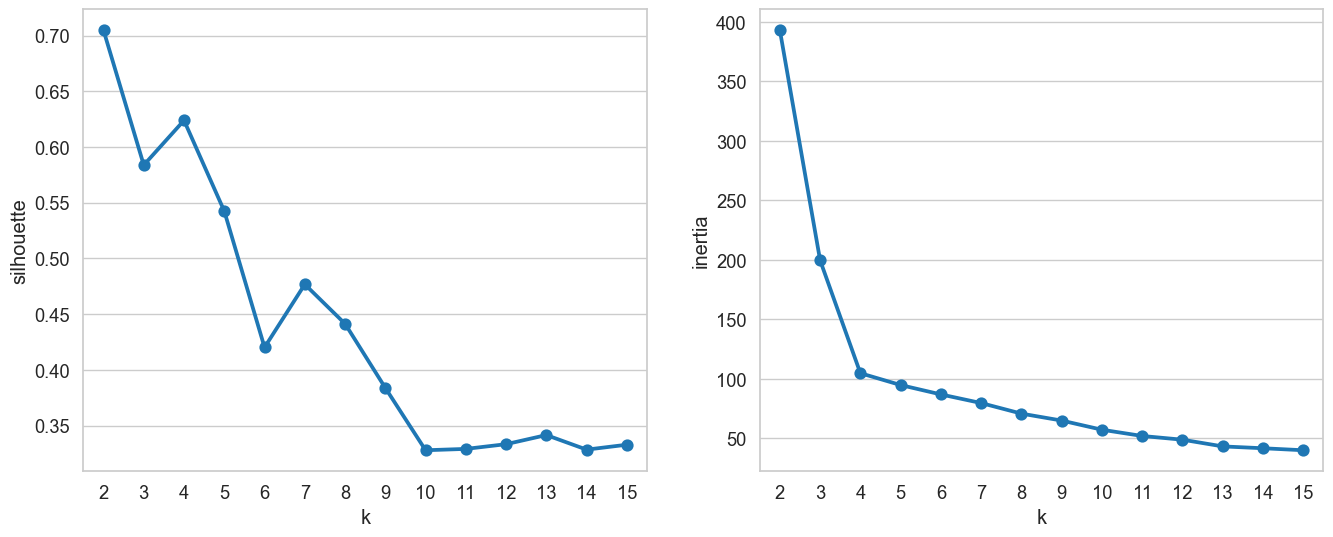

In [15]:
from sklearn import metrics

X = dataset_blops[['x1','x2']].values

clf = KMeans(init='k-means++')

s_sil = []
s_in = []
for k in range(2,16):
    clf.n_clusters = k
    clf.fit(X)
    labels = clf.labels_
    s_sil.append(metrics.silhouette_score(X, labels))
    s_in.append(clf.inertia_)

cluster_evaluation = pd.DataFrame()
cluster_evaluation['k'] = range(2,16)
cluster_evaluation['silhouette'] = s_sil
cluster_evaluation['inertia'] = s_in
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.pointplot(x="k", y="silhouette", data=cluster_evaluation)
plt.subplot(1,2,2)
sns.pointplot(x="k", y="inertia", data=cluster_evaluation)
plt.show()

Hierarchical **agglomerative** clustering is an algorithm that produces a clustered visualization of a data set without having to set the number of cluster $k$ in advance. The idea is to start with a singleton cluster, and clusters are iteratively merged until one single cluster remains. This results in a "cluster tree," which is also called a **dendogram**.

The algorithm can be summarized as follows:

1. represent each data point as a singleton cluster (a cluster with just one data point)
2. merge the two closest clusters 
3. repeat step 2. until one single cluster remains

So what does that mean *merge the two closest clusters*? In general we consider three possibilities (the best method depends on the data set and as such this choice can be considered a hyperparameter of hierarchical agglomerative clustering).

**Complete linkage** compares the most dissimilar members between clusters in each iteration (step 2.). The two clusters that have the most similar *dissimilar members* are merged into a new cluster. We can write this as 

<br>
$$d(A,B) = \max(dist(A_i, B_j))$$
<br>

where $A_i$ ranges over all data points in cluster $A$ and $B_j$ ranges over all data points in cluster $B$.
 
**Single linkage** compares the two most similar members between clusters in each iteration:

<br>
$$d(A,B) = \min(dist(A_i, B_j)).$$
<br>

**Average linkage** computes the mean distance between the members of each cluster:

<br>
$$d(A,B) = \frac{1}{|A||B|}\sum_{A_i \in A}\sum_{B_j \in B}dist(A_i,B_j).$$
<br>

Let's consider the following data set:

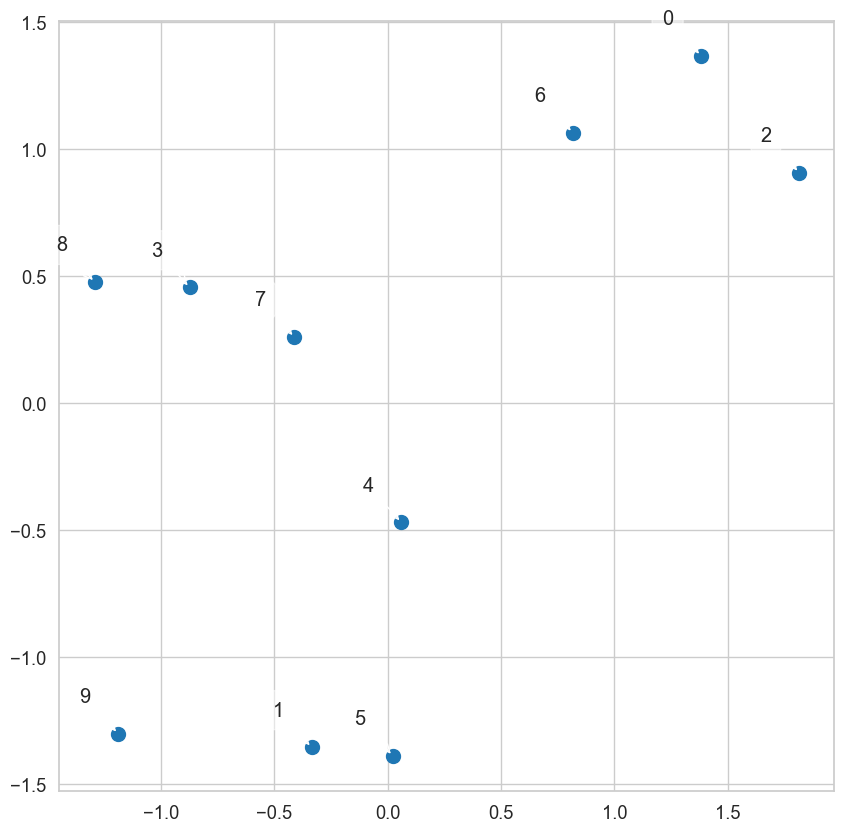

In [16]:
dataset_hc = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/7_clustering/dataset_hc.csv")
plot_scatter_annotated(dataset_hc,range(len(dataset_hc)))
plt.show()

We can plot the pairwise distances between the data points as a distance matrix: 

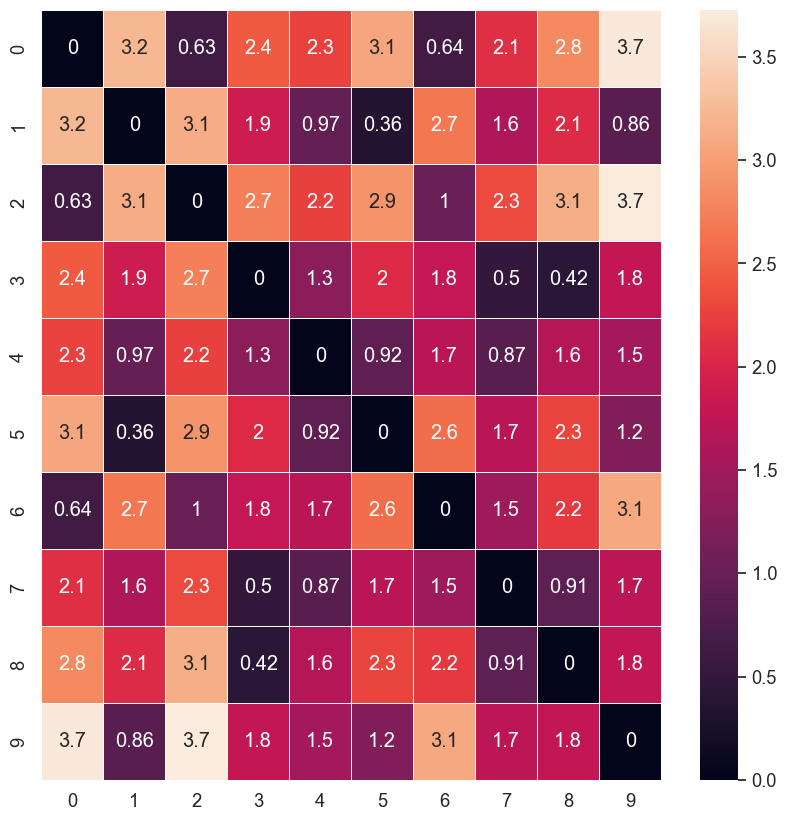

In [17]:
from scipy.spatial.distance import pdist, squareform

distxy = squareform(pdist(dataset_hc, metric='euclidean'))

plt.figure(figsize=(10,10))
sns.heatmap(distxy, annot=True, linewidths=.5)
plt.show()

We can then use this distance matrix to compute a cluster dendogram:

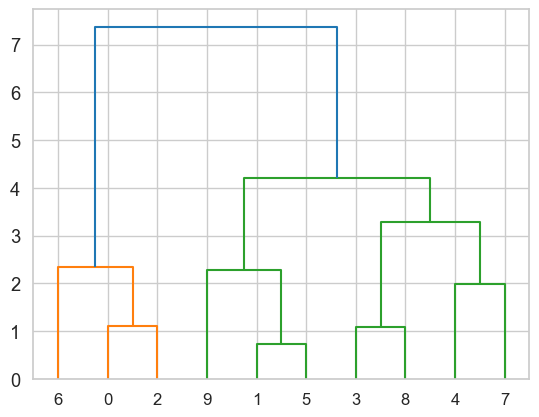

In [18]:
# perform clustering and plot the dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

R = dendrogram(linkage(distxy, method='complete'))

In hierarchical agglomerative clustering both the rows and the columns in the data set can be clustered simultaneously. In the python seaborn package there is a function called `clustermap()` that performs hierarchical clustering of a data matrix:

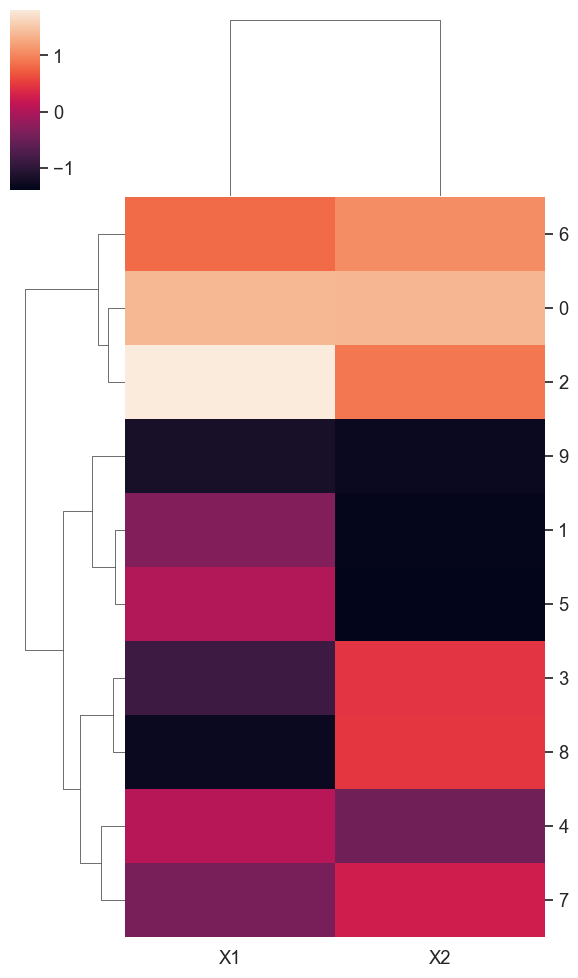

In [19]:
cg = sns.clustermap(dataset_hc,method="complete",figsize=(6,10))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

This is a typical result of a hierarchical agglomerative clustering where both cluster dendograms are shown alongside a heatmap that represents the feature values as colors. 

Let's consider a gene expression dataset with 63 data points that represent samples that belong to one of two classes: breast cancer or colon cancer. For each sample the expression value of 109 selected genes were measured, these constitute the features. To facilitate the interpretation of the result of a hierarchical clustering it is useful provide identifiers for both the rows and the columns in a data set. The identifiers for the columns are the feature names provides in the first line (the header) a the data set. For the row identifiers we have to tell pandas which row tu use for this by setting the `index_col` function argument of `read_csv()`. This way the hierarchical clustering tool knows that this is a row identifier column that should be used as a data point feature:

In [20]:
dataset_genes = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/7_clustering/AP_Breast_Colon.csv",index_col=0)
tissue = dataset_genes.pop('Tissue')
print(dataset_genes.shape)

(63, 109)


In [21]:
tissue.value_counts()

Tissue
Breast    43
Colon     20
Name: count, dtype: int64

In [22]:
dataset_genes.head()

,202345_s_at,212274_at,218857_s_at,211699_x_at,201671_x_at,207783_x_at,202173_s_at,223678_s_at,219274_at,215446_s_at,...,238763_at,225915_at,201063_at,204362_at,218351_at,208539_x_at,210119_at,222468_at,218936_s_at,200727_s_at
ID_REF,,,,,,,,,,,,,,,,,,,,,
152585,2520.2,235.7,1016.2,774.3,1688.3,65106.5,2161.3,177.8,424.6,2203.5,...,176.3,560.2,1901.9,912.5,2744.7,26.2,149.1,1234.1,979.6,879.0
53147,540.9,293.2,275.3,305.2,1197.1,18805.4,857.1,470.1,159.0,579.6,...,156.2,409.8,2431.7,687.4,1185.0,329.1,105.4,1073.4,216.5,912.6
89019,1242.3,1383.3,1274.4,974.5,1266.8,64710.1,2644.9,11.8,149.7,920.0,...,89.4,1476.7,2646.1,1677.6,1833.4,166.2,72.4,971.8,1250.1,2329.1
76611,8430.8,2313.3,725.9,2831.8,1296.1,86801.8,1922.9,10.0,1179.8,1681.5,...,135.4,340.9,2857.1,2189.4,3172.4,718.1,332.7,529.1,1387.3,888.7
76637,2258.8,473.6,64.5,4936.5,1872.4,132190.0,1743.4,25.9,342.5,2115.0,...,12.8,764.8,3097.4,1172.5,817.2,37.0,168.4,1866.0,821.2,1000.2


We first take a look at the individual features:

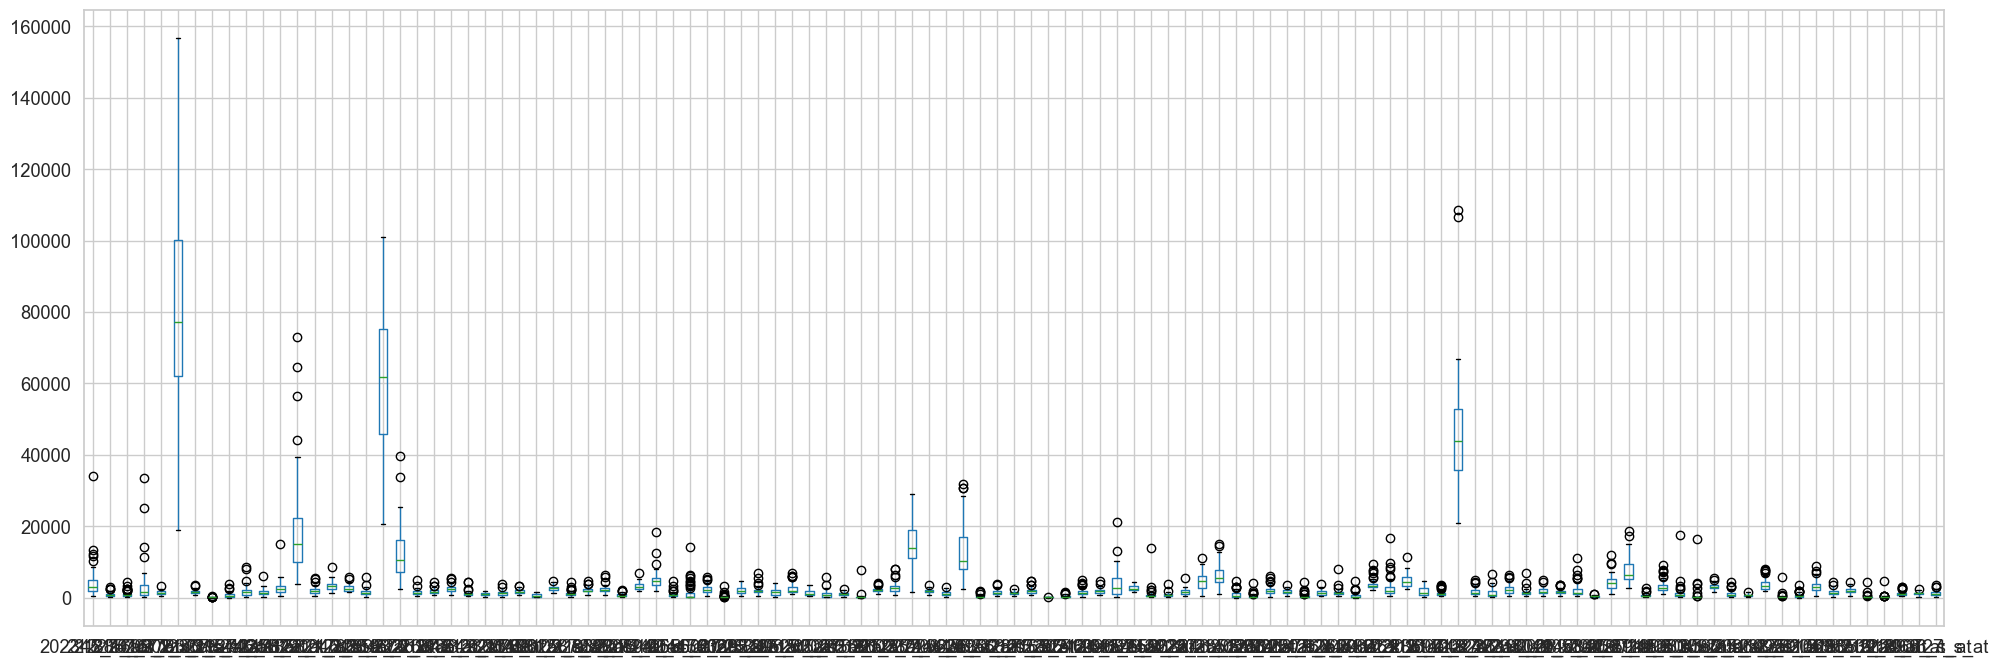

In [23]:
plt.figure(figsize=(24,8))
dataset_genes.boxplot()
plt.show()

We clearly need to normalize or standardize these features:

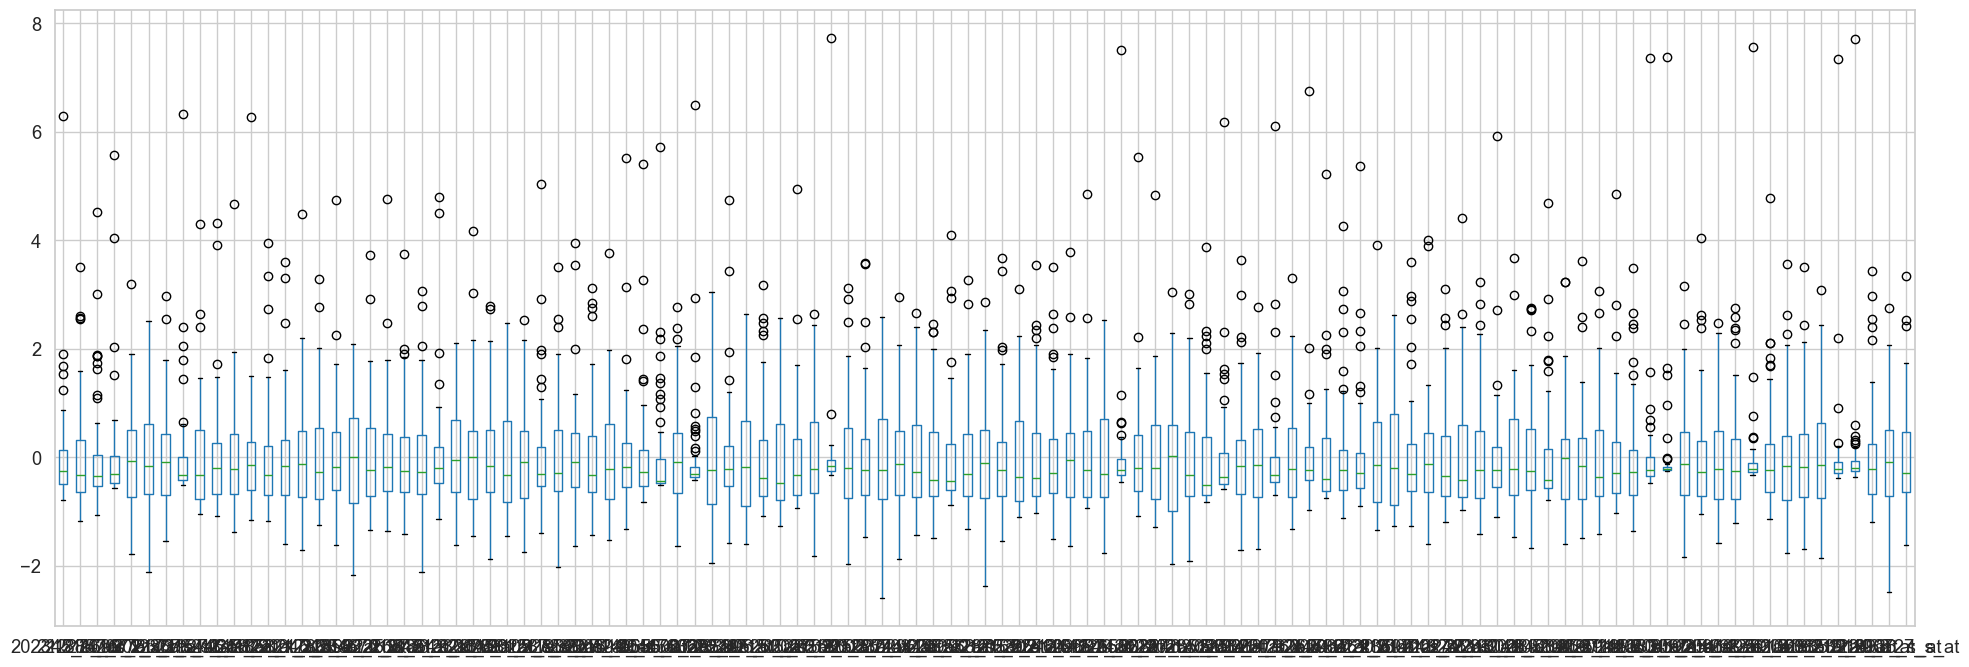

In [24]:
from sklearn.preprocessing import StandardScaler

dataset_genes_cols = dataset_genes.columns.values
scaler = StandardScaler()
scaler.fit(dataset_genes)
dataset_genes_norm = pd.DataFrame(scaler.transform(dataset_genes),columns=dataset_genes_cols)
plt.figure(figsize=(24,8))
dataset_genes_norm.boxplot()
plt.show()

We can then use the `clustermap()` function to compute the hierarchical clustering. As we know the classes of the data points (remark that these were not used to perform the clustering) in the data set we can plot these as well (blue indicates colon cancer, yellow indicates breast cancer):

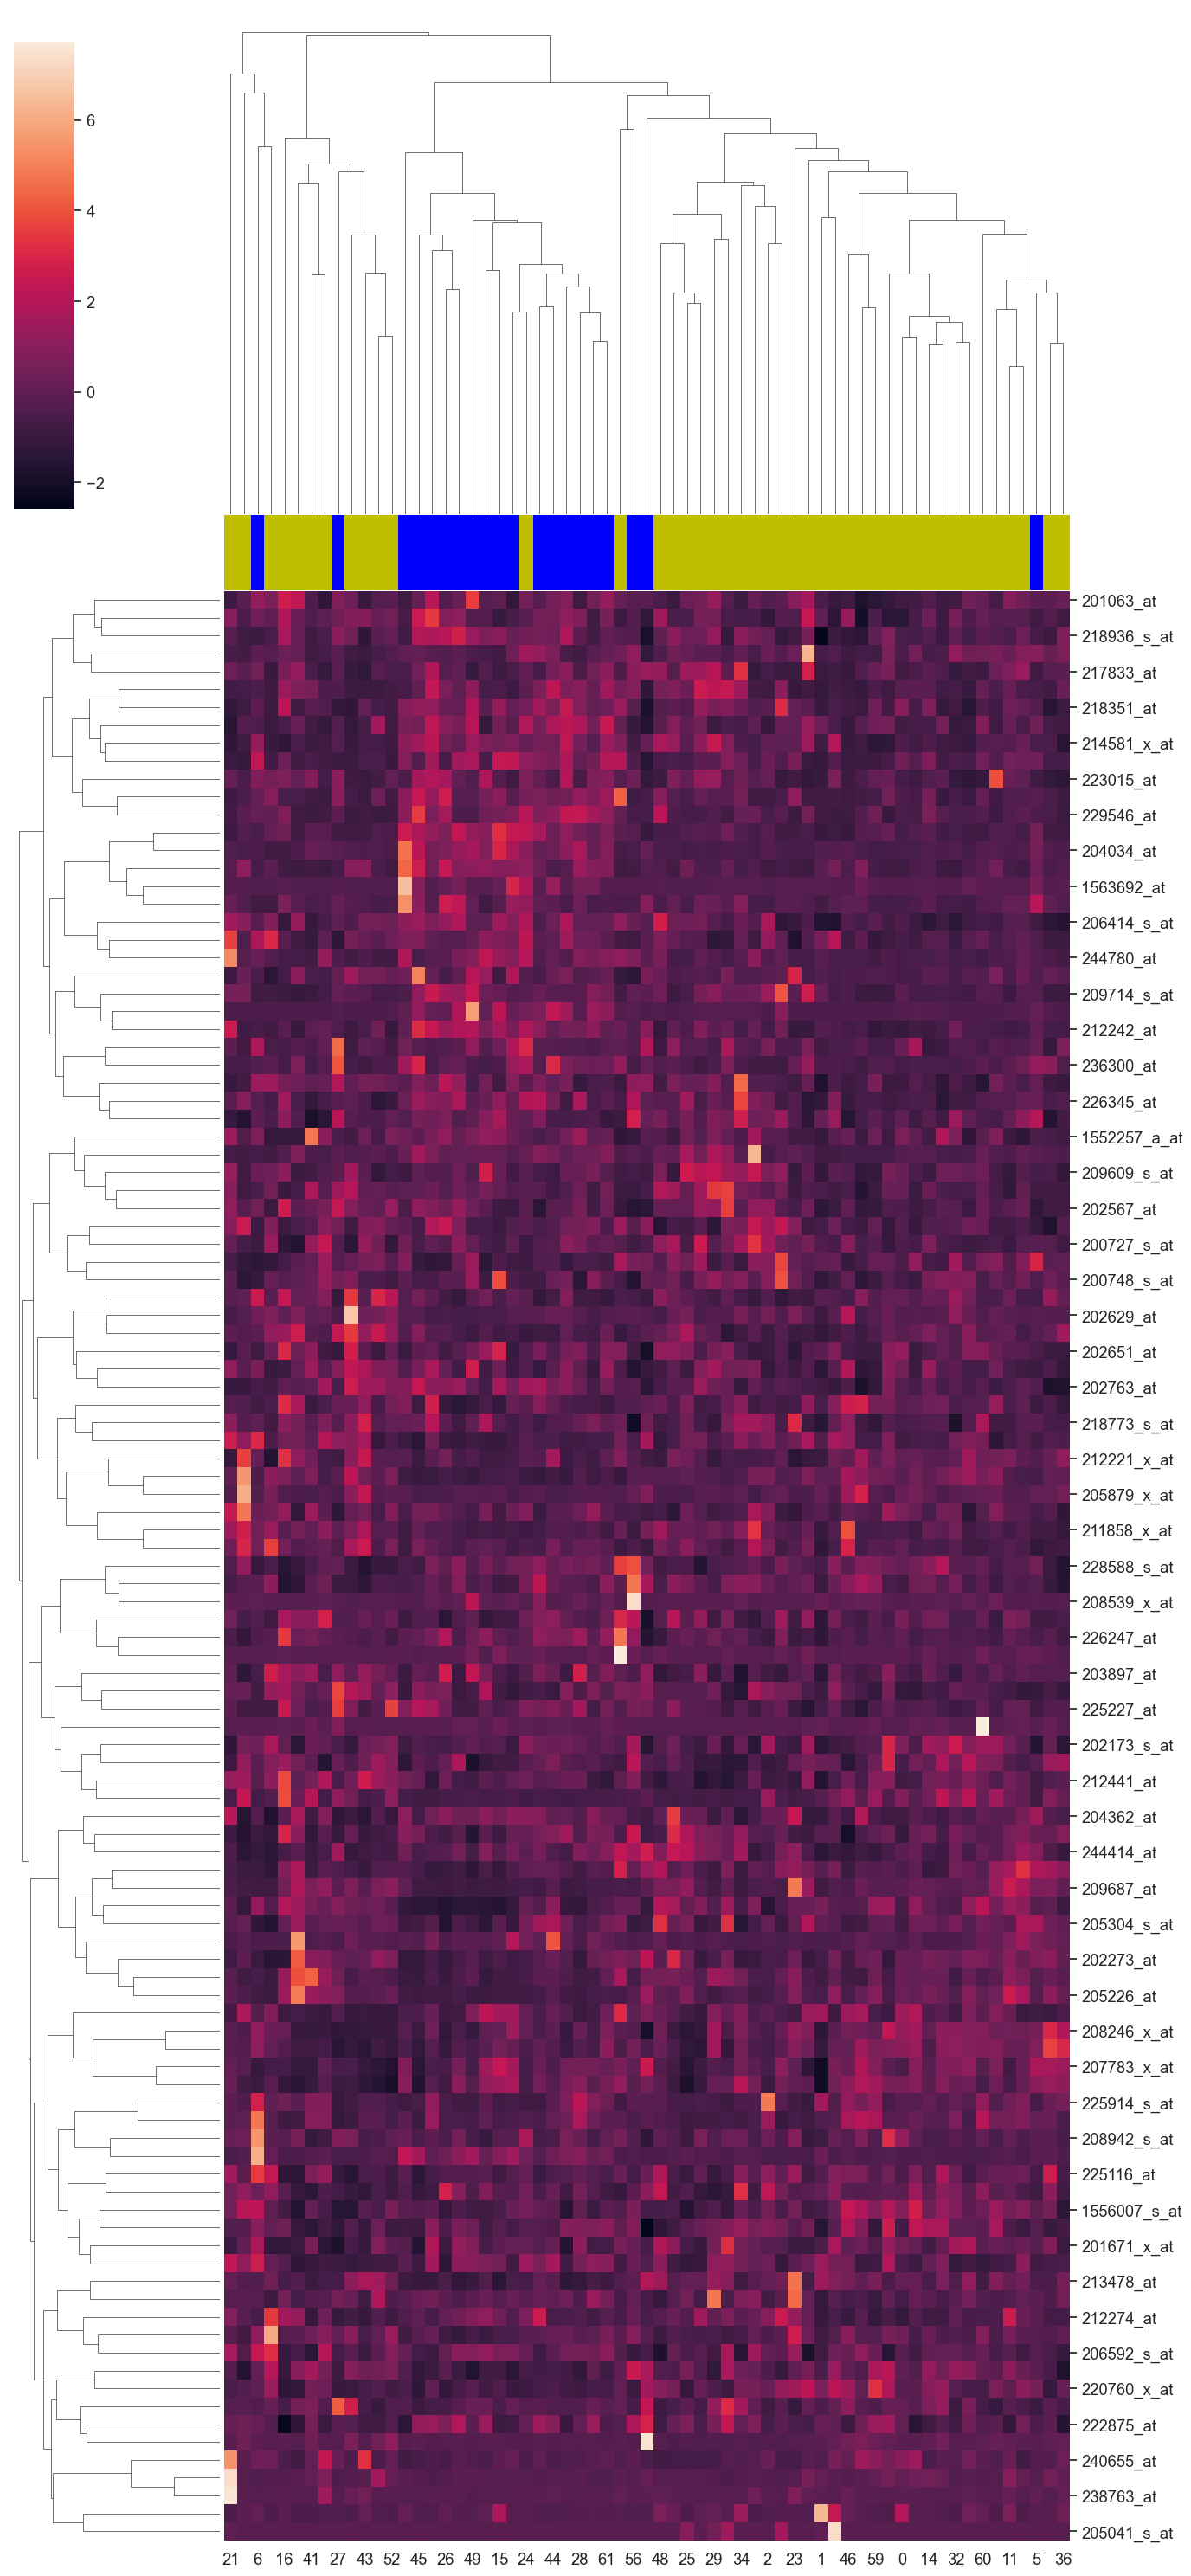

In [25]:
class_colors = ['y' if x == 'Breast' else 'b' for x in tissue]
cg = sns.clustermap(dataset_genes_norm.T,method="complete",col_colors=class_colors,figsize=(14,30))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()